In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [124]:
df = pd.read_csv('BTC-USD.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-23,32985.757813,33360.976563,31493.160156,32067.642578,32067.642578,48354737975
1,2021-01-24,32064.376953,32944.007813,31106.685547,32289.378906,32289.378906,48643830599
2,2021-01-25,32285.798828,34802.742188,32087.787109,32366.392578,32366.392578,59897054838
3,2021-01-26,32358.613281,32794.550781,31030.265625,32569.849609,32569.849609,60255421470
4,2021-01-27,32564.029297,32564.029297,29367.138672,30432.546875,30432.546875,62576762015


In [125]:
df.shape

(1096, 7)

In [126]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03
mean,34991.650842,35769.312710,34142.188598,34993.077074,34993.077074,3.095933e+10
std,12609.617545,12971.070409,12179.894275,12604.432937,12604.432937,1.968249e+10
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09
25%,24738.201172,25228.042969,24302.009765,24719.875000,24719.875000,1.837778e+10
50%,32539.872071,33719.931640,31256.747071,32537.754883,32537.754883,2.739475e+10
75%,43798.200195,44430.390625,42785.268555,43792.700195,43792.700195,3.776437e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [127]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1096 non-null   object 
 1   Open       1096 non-null   float64
 2   High       1096 non-null   float64
 3   Low        1096 non-null   float64
 4   Close      1096 non-null   float64
 5   Adj Close  1096 non-null   float64
 6   Volume     1096 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.1+ KB


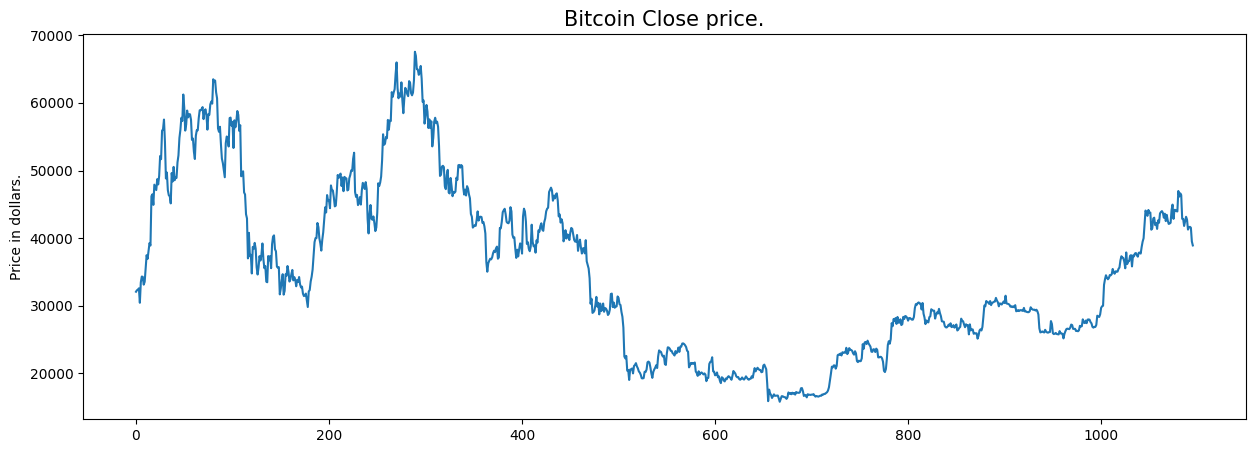

In [128]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()


In [129]:
df[df['Close'] == df['Adj Close']].shape


(1096, 7)

In [130]:
df = df.drop(['Adj Close'], axis=1)


In [131]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

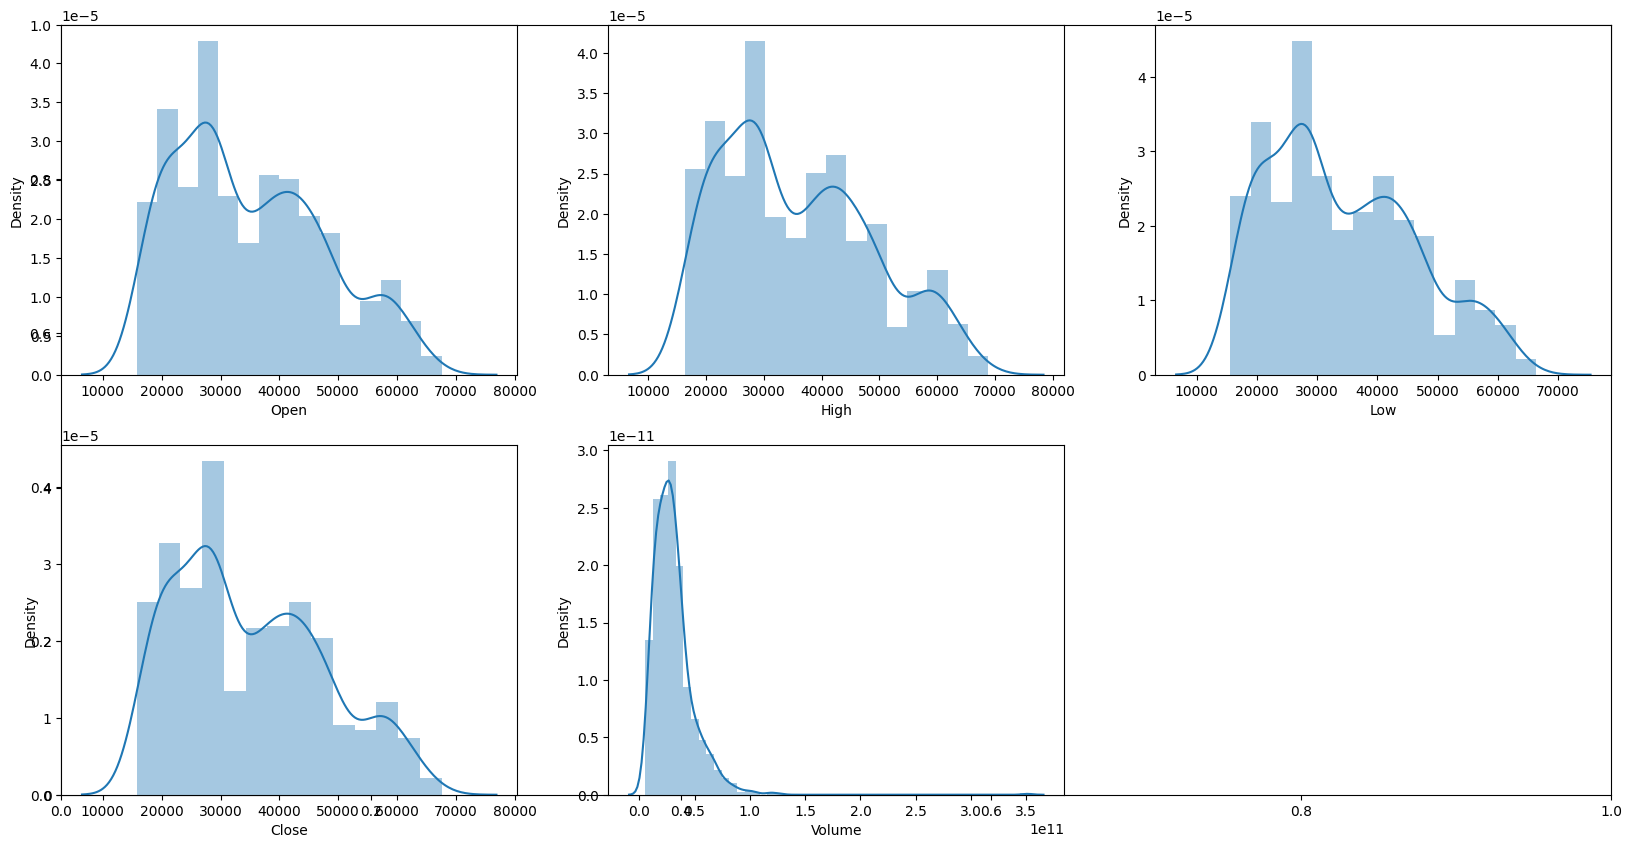

In [132]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.distplot(df[col])
plt.show()

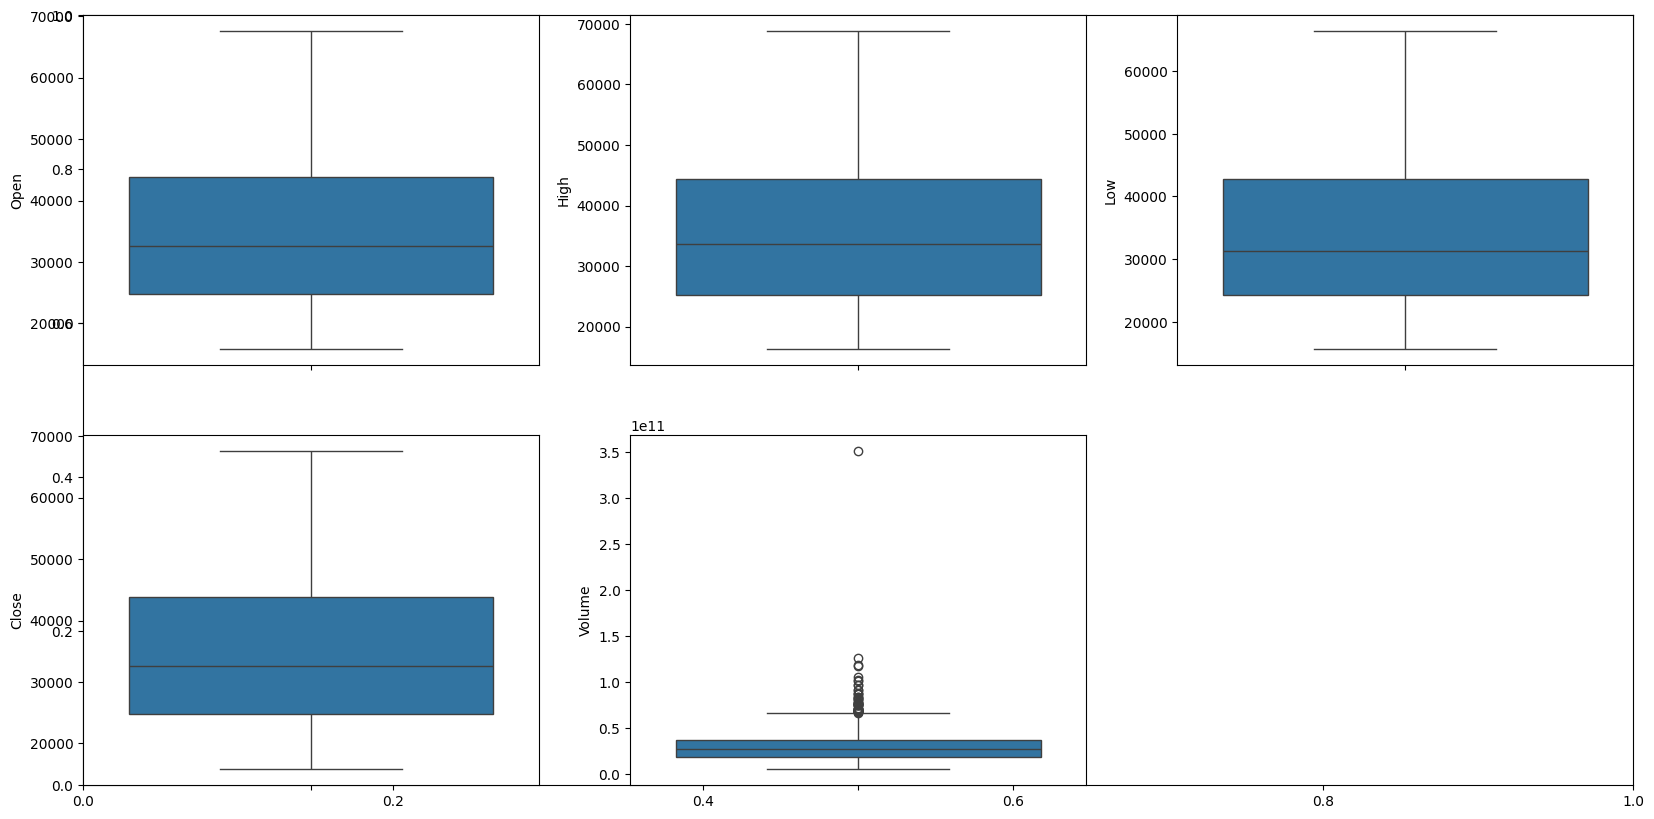

In [133]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.boxplot(df[col])
plt.show()

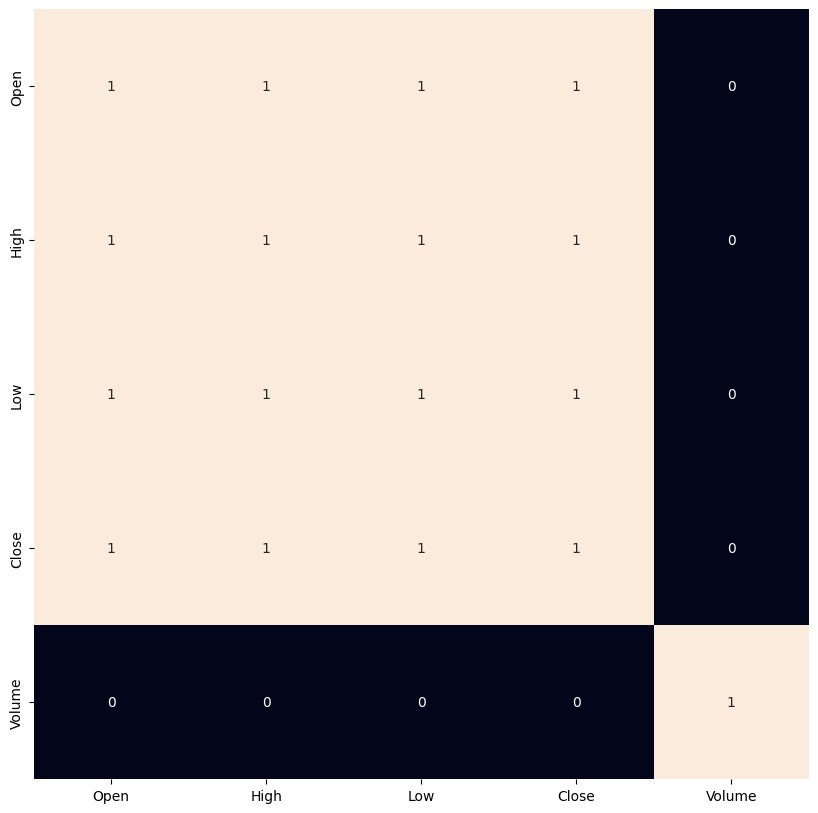

In [134]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sns.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

### 2. 4 technical indicators a. Moving Average(MA) b. Relative Strength Index (RSI) c. Bollinger Bands d. MACD (Moving Average Convergence Divergence 

In [135]:
# Function to calculate Moving Average (MA)
def calculate_ma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()

    upper_band = sma + 2 * rolling_std
    lower_band = sma - 2 * rolling_std
    
    return upper_band, lower_band

# Function to calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd, signal_line

# Add calculated indicators to the DataFrame
df['MA'] = calculate_ma(df, window=50)
df['RSI'] = calculate_rsi(df)
df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df)
df['MACD'], df['Signal_Line'] = calculate_macd(df)
# squeeze close price in range 0-1 based on upper and lower band values
df['b_Indicator'] = np.abs(df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])

#handle nan with avg
df['MA'].fillna(df['MA'].mean(), inplace=True)
df['RSI'].fillna(df['RSI'].mean(), inplace=True)
df['Upper_Band'].fillna(df['Upper_Band'].mean(), inplace=True)
df['Lower_Band'].fillna(df['Lower_Band'].mean(), inplace=True)
df['MACD'].fillna(df['MACD'].mean(), inplace=True)
df['Signal_Line'].fillna(df['Signal_Line'].mean(), inplace=True)
df['b_Indicator'].fillna(df['b_Indicator'].mean(), inplace=True)

# Print the updated DataFrame
df.tail()

,Date,Open,High,Low,Close,Volume,MA,RSI,Upper_Band,Lower_Band,MACD,Signal_Line,b_Indicator
1091,2024-01-19,41278.460938,42134.160156,40297.457031,41618.406250,25752407154,43041.810625,40.218229,47185.057958,40355.143995,-204.501097,249.187241,0.184960
1092,2024-01-20,41624.589844,41877.894531,41446.824219,41665.585938,11586690904,43101.347344,40.979022,47220.605317,40259.636480,-291.090042,141.131784,0.201976
1093,2024-01-21,41671.488281,41855.367188,41497.007813,41545.785156,9344043642,43142.736406,40.745843,47216.911874,40001.175235,-365.169875,39.871452,0.214061
1094,2024-01-22,41553.652344,41651.207031,39450.117188,39507.367188,31338708143,43133.315938,18.809080,47319.320938,39353.706015,-581.656992,-84.434236,0.019291
1095,2024-01-23,39518.714844,40125.042969,38660.816406,38916.828125,31826454528,43072.050547,19.194513,47585.415881,38694.476306,-791.749364,-225.897262,0.025009


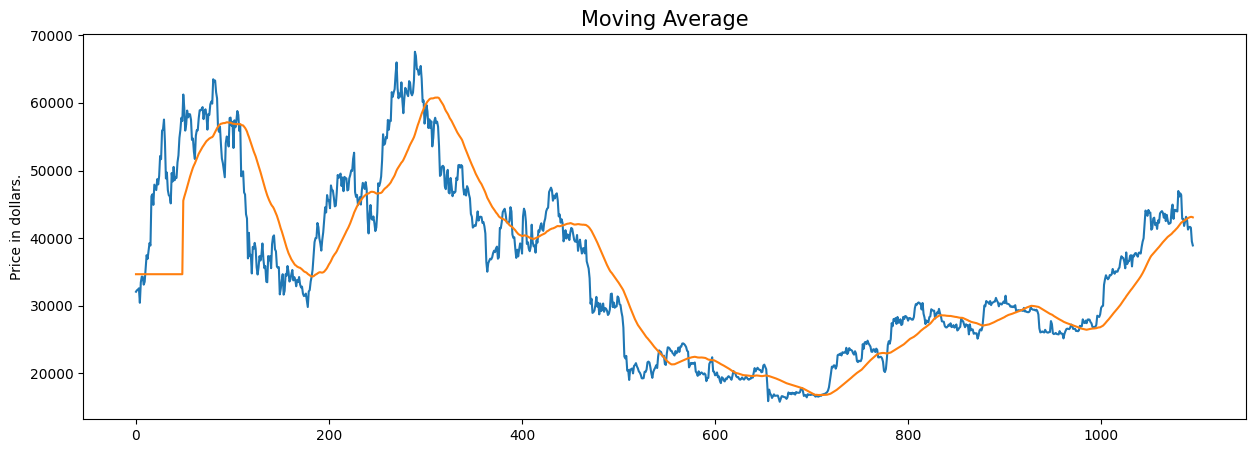

In [136]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.plot(df['MA'])
plt.title('Moving Average', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [137]:
# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7, 0.3], subplot_titles=('Price Chart', 'RSI'))

# Candlestick chart
candlestick = go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             name='Candlesticks')

fig.add_trace(candlestick, row=1, col=1)

# Scatter plot for RSI
scatter = go.Scatter(x=df['Date'], y=df['RSI'], mode='markers', marker=dict(color='red'), name='RSI')

# Add indicator lines for min/max of RSI
min_rsi_line = go.Scatter(x=df['Date'], y=[30] * len(df), mode='lines', name='Oversold Threshold', line=dict(color='blue'))
max_rsi_line = go.Scatter(x=df['Date'], y=[70] * len(df), mode='lines', name='Overbought Threshold', line=dict(color='green'))

fig.add_trace(scatter, row=2, col=1)
fig.add_trace(min_rsi_line, row=2, col=1)
fig.add_trace(max_rsi_line, row=2, col=1)

# Customize layout
fig.update_layout(title_text='BTC-USD Price and RSI Analysis',
                  xaxis_rangeslider_visible=False)

# Display the chart directly in the Jupyter Notebook
fig.show()


In [138]:
# Normalize All Indicators
df['MA_norm'] = (df['MA'] - df['MA'].mean()) / df['MA'].std()
df['RSI_norm'] = (df['RSI'] - df['RSI'].mean()) / df['RSI'].std()
df['MACD_norm'] = (df['MACD'] - df['MACD'].mean()) / df['MACD'].std()
df['Signal_Line_norm'] = (df['Signal_Line'] - df['Signal_Line'].mean()) / df['Signal_Line'].std()
df['b_Indicator_norm'] = (df['b_Indicator'] - df['b_Indicator'].mean()) / df['b_Indicator'].std()

### 4. Calulating Correlation Matrix

In [139]:
correlation_matrix = df[['Close', 'MA_norm', 'RSI_norm', 'MACD_norm', 'b_Indicator']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                Close   MA_norm  RSI_norm  MACD_norm  b_Indicator
Close        1.000000  0.892350  0.153821   0.336475     0.112056
MA_norm      0.892350  1.000000 -0.152699  -0.102290    -0.172469
RSI_norm     0.153821 -0.152699  1.000000   0.662975     0.834835
MACD_norm    0.336475 -0.102290  0.662975   1.000000     0.544969
b_Indicator  0.112056 -0.172469  0.834835   0.544969     1.000000


### 5. Calculating the combined indicator using weighted average

In [140]:
# Adjusting (inversing values) to account for bullish/bearing pattern
df['RSI_norm'] = 1 / df['RSI_norm']

In [141]:
weights = correlation_matrix['Close'].drop('Close')  # Use correlation with Close as weights
weights = weights / weights.sum()
combined_indicator = df[['MA_norm', 'RSI_norm', 'MACD_norm', 'b_Indicator']].mul(weights).sum(axis=1) / weights.sum()

# Add combined indicator to the DataFrame
df['Combined_Indicator'] = combined_indicator


In [142]:
weights

MA_norm        0.597008
RSI_norm       0.102911
MACD_norm      0.225112
b_Indicator    0.074969
Name: Close, dtype: float64

### 6. Methodology to predict bullish and bearish positions. We'll use Logistic Regression as a simple classification model
### Bullish: 1, Bearish: 0

In [143]:
df['Position'] = (df['Combined_Indicator'] > 0).astype(int)

### 7. Accuracy of prediction

In [144]:
df['Position'].value_counts()

Position
0    562
1    534
Name: count, dtype: int64

In [145]:
X = df[['MA_norm', 'RSI_norm', 'MACD_norm', 'b_Indicator']]
y = df['Position']

# Fill missing values with column means
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [146]:
# predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of prediction: {accuracy * 100:.2f}%")


Accuracy of prediction: 89.06%


In [147]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       163
           1       0.90      0.89      0.89       166

    accuracy                           0.89       329
   macro avg       0.89      0.89      0.89       329
weighted avg       0.89      0.89      0.89       329



# Saving Predictions based on Position

In [148]:
# Add 'Prediction' column based on 'Position'
df['Prediction'] = df['Position'].apply(lambda x: 'L' if x == 1 else 'S')

# Save the DataFrame to a new CSV file
df.to_csv('BTC_Predictions.csv', index=False)

# Display the first few rows of the updated DataFrame
print(df.head())

# Save the DataFrame to a new CSV file
df.to_csv('BTC_Predictions.csv', index=False)

         Date          Open          High           Low         Close  \
0  2021-01-23  32985.757813  33360.976563  31493.160156  32067.642578   
1  2021-01-24  32064.376953  32944.007813  31106.685547  32289.378906   
2  2021-01-25  32285.798828  34802.742188  32087.787109  32366.392578   
3  2021-01-26  32358.613281  32794.550781  31030.265625  32569.849609   
4  2021-01-27  32564.029297  32564.029297  29367.138672  30432.546875   

        Volume            MA        RSI    Upper_Band    Lower_Band  ...  \
0  48354737975  34660.532652  51.325272  38792.291061  31084.166651  ...   
1  48643830599  34660.532652  51.325272  38792.291061  31084.166651  ...   
2  59897054838  34660.532652  51.325272  38792.291061  31084.166651  ...   
3  60255421470  34660.532652  51.325272  38792.291061  31084.166651  ...   
4  62576762015  34660.532652  51.325272  38792.291061  31084.166651  ...   

   Signal_Line  b_Indicator       MA_norm      RSI_norm  MACD_norm  \
0     0.000000     0.521249  6.100